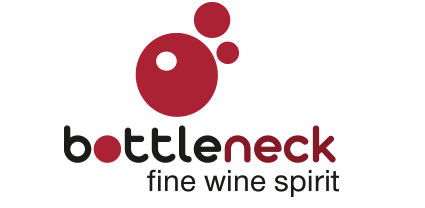

<h1><center> Optimisation de la gestion des données de ventes

In [1]:
# import des librairies nécessaires à l'analyse.

import pandas as pd
import numpy as numpy
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# import des fichiers 
erp=pd.read_excel('erp.xlsx')
web=pd.read_excel('web.xlsx')
liaison=pd.read_excel('liaison.xlsx')

## I. Rapprochement des données de l'ERP avec celles du CRM

### I.A Revue et retraitement des fichiers
Passons en revue les différents fichiers afin d'identifier les informations contenues et le format des données.

#### Données de l'erp



In [3]:
erp.info()
erp.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 825 entries, 0 to 824
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   product_id      825 non-null    int64  
 1   onsale_web      825 non-null    int64  
 2   price           825 non-null    float64
 3   stock_quantity  825 non-null    int64  
 4   stock_status    825 non-null    object 
dtypes: float64(1), int64(3), object(1)
memory usage: 32.4+ KB


,product_id,onsale_web,price,stock_quantity,stock_status
0,3847,1,24.2,0,outofstock
1,3849,1,34.3,0,outofstock
2,3850,1,20.8,0,outofstock
3,4032,1,14.1,0,outofstock
4,4039,1,46.0,0,outofstock


In [39]:
len(erp['product_id'].unique())

825

In [4]:
erp["onsale_web"].value_counts()

1    717
0    108
Name: onsale_web, dtype: int64

#### Données du CRM

In [5]:
web.info()
web.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1513 entries, 0 to 1512
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   sku                    1428 non-null   object        
 1   virtual                1513 non-null   int64         
 2   downloadable           1513 non-null   int64         
 3   rating_count           1513 non-null   int64         
 4   average_rating         1430 non-null   float64       
 5   total_sales            1430 non-null   float64       
 6   tax_status             716 non-null    object        
 7   tax_class              0 non-null      float64       
 8   post_author            1430 non-null   float64       
 9   post_date              1430 non-null   datetime64[ns]
 10  post_date_gmt          1430 non-null   datetime64[ns]
 11  post_content           0 non-null      float64       
 12  post_title             1430 non-null   object        
 13  pos

,sku,virtual,downloadable,rating_count,average_rating,total_sales,tax_status,tax_class,post_author,post_date,...,post_name,post_modified,post_modified_gmt,post_content_filtered,post_parent,guid,menu_order,post_type,post_mime_type,comment_count
0,bon-cadeau-25-euros,0,0,0,0.0,10.0,taxable,NaN,1.0,2018-06-01 13:53:46,...,bon-cadeau-de-25-euros,2018-06-01 14:13:57,2018-06-01 12:13:57,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
1,15298,0,0,0,0.0,6.0,taxable,NaN,2.0,2018-02-08 12:58:52,...,pierre-jean-villa-saint-joseph-preface-2018,2019-12-30 09:30:29,2019-12-30 08:30:29,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
2,15296,0,0,0,0.0,0.0,taxable,NaN,2.0,2018-02-08 13:49:41,...,pierre-jean-villa-saint-joseph-tilde-2017,2019-12-21 09:00:17,2019-12-21 08:00:17,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
3,15300,0,0,0,0.0,0.0,taxable,NaN,2.0,2018-02-08 14:08:36,...,pierre-jean-villa-croze-hermitage-accroche-coe...,2020-06-26 18:15:03,2020-06-26 16:15:03,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
4,19814,0,0,0,0.0,3.0,taxable,NaN,2.0,2018-02-09 14:01:05,...,pierre-jean-villa-igp-gamine-2018,2020-01-04 16:36:01,2020-01-04 15:36:01,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0


In [41]:
len(web['sku'].unique())

715

Le fichier CRM contient de nombreuses informations qui ne sont pas nécessairement utiles pour l'analyse du chiffre d'affaires et des prix.
Nous cherchons à créer un nouveau dataframe avec uniquement les données utiles à l'analyse demandée à savoir le volume de ventes associé à chaque référence produit.

In [6]:
# identifions le nombre de références et le nombre de ligne de chaque référence
web["sku"].value_counts(dropna=False, ascending=False).to_frame()

,sku
NaN,85
15032.0,2
15717.0,2
14692.0,2
15715.0,2
...,...
16041.0,2
16039.0,2
16038.0,2
16037.0,2


In [7]:
#identifions si références de produits NaN sont associées à des valeurs non-nulles
web[web["sku"].isnull()].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85 entries, 178 to 796
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   sku                    0 non-null      object        
 1   virtual                85 non-null     int64         
 2   downloadable           85 non-null     int64         
 3   rating_count           85 non-null     int64         
 4   average_rating         2 non-null      float64       
 5   total_sales            2 non-null      float64       
 6   tax_status             2 non-null      object        
 7   tax_class              0 non-null      float64       
 8   post_author            2 non-null      float64       
 9   post_date              2 non-null      datetime64[ns]
 10  post_date_gmt          2 non-null      datetime64[ns]
 11  post_content           0 non-null      float64       
 12  post_title             2 non-null      object        
 13  post

In [8]:
# Vérifions si les valeurs non-nulles de la colonne "total sales" contiennent des informations
web[web["sku"].isnull() & web["total_sales"].notnull()]

,sku,virtual,downloadable,rating_count,average_rating,total_sales,tax_status,tax_class,post_author,post_date,...,post_name,post_modified,post_modified_gmt,post_content_filtered,post_parent,guid,menu_order,post_type,post_mime_type,comment_count
470,NaN,0,0,0,0.0,0.0,taxable,NaN,2.0,2018-07-31 12:07:23,...,pierre-jean-villa-cote-rotie-fongeant-2017,2019-11-02 13:24:15,2019-11-02 12:24:15,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
471,NaN,0,0,0,0.0,0.0,taxable,NaN,2.0,2018-08-08 11:23:43,...,pierre-jean-villa-condrieu-suspendu-2018,2019-11-02 13:24:01,2019-11-02 12:24:01,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0


les 85 références produits "nan" ne contiennent pas d'information utiles pour l'analyse nous ne les inclurons donc pas dans notre nouveau dataframe.

In [9]:
# suppression des valeurs nulles
web_clean=web[web["sku"].notnull()].reset_index(drop=True)
web_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1428 entries, 0 to 1427
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   sku                    1428 non-null   object        
 1   virtual                1428 non-null   int64         
 2   downloadable           1428 non-null   int64         
 3   rating_count           1428 non-null   int64         
 4   average_rating         1428 non-null   float64       
 5   total_sales            1428 non-null   float64       
 6   tax_status             714 non-null    object        
 7   tax_class              0 non-null      float64       
 8   post_author            1428 non-null   float64       
 9   post_date              1428 non-null   datetime64[ns]
 10  post_date_gmt          1428 non-null   datetime64[ns]
 11  post_content           0 non-null      float64       
 12  post_title             1428 non-null   object        
 13  pos

In [10]:
#nombre de références produits
len(web_clean["sku"].unique())

714

Nous constatons qu'il y a 714 références produits pour 1428 entrées dans notre dataframe, il semble que chaque référence est reprise deux fois à cause et que la colonne tax_status pourrait nous permettre de filtrer les données.
Nous vérifions que c'est bien le cas.

In [11]:
# Vérifions les volumes de ventes par tax status est le même.
web_clean.loc[web_clean["tax_status"]=="taxable", "total_sales"].sum()

2865.0

In [12]:
web_clean.loc[web_clean["tax_status"].isna(), "total_sales"].sum()

2865.0

In [13]:
# Nous vérifions que chaque tax status correspond bien à 714 reférences produits différentes.
len(web_clean.loc[web_clean["tax_status"]=="taxable", "sku"].unique())

714

In [14]:
len(web_clean.loc[web_clean["tax_status"].isna(), "sku"].unique())

714

Pour faire les analyses nous avons besoin uniquement des références produits et du volumes associé à chaque référence. Cette information est dans la colonne "Total Sales". Nous créons donc un dataframe simplifié, contenant uniquement les valeurs utiles

In [15]:
web_clean=web_clean.loc[web_clean["tax_status"]=="taxable",["sku", "total_sales", "post_name"]]

In [16]:
web_clean.rename(columns={"total_sales": "volume_sales"}, inplace=True)

#### Données du fichier liaison

In [17]:
liaison.info()
liaison.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 825 entries, 0 to 824
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   product_id  825 non-null    int64 
 1   id_web      734 non-null    object
dtypes: int64(1), object(1)
memory usage: 13.0+ KB


,product_id,id_web
0,3847,15298
1,3849,15296
2,3850,15300
3,4032,19814
4,4039,19815


In [45]:
len(liaison['product_id'].unique())

825

In [18]:
# rectifions le nom des colonnes comme indiqué par Sylvie
liaison.columns=["product_id", "sku"]

In [46]:
len(liaison['sku'].unique())

735

Résultats de l'exploration préliminaires des données :
- il y a 825 références produits dans le fichiers erp, ce chiffre est bien repris dans le fichier de liaison.

- dans le fichier web il y a 714 références sku mais il y en a 734 dans le fichier de liaison
- dans le fichier erp il y a 717 sur 825 reférences indiquées comme vendues en ligne et 108 non vendues en ligne.


### I.B Rapprochement des données
#### I.B. 1) intégration des données pertinentes dans un seul dataframe

In [20]:
# intégrons les références sku du fichier de liaison dans le fichier erp
erp_liaison=erp.merge(liaison, how="left")
# vérifions si les références sku manquantes correspondent toutes à des produits non vendus en ligne
erp_liaison[erp_liaison["sku"].isnull()]["onsale_web"].value_counts()

0    88
1     3
Name: onsale_web, dtype: int64

In [21]:
# Vérifions si il y a des références dans le fichier web qui ne figure pas dans le fichier de liaison
ref_manquantes=[]
for A in web["sku"].unique():
     if A not in liaison["sku"].unique():
            ref_manquantes.append(A)
ref_manquantes

[nan]

In [22]:
# intégrons les références du fichier de liaison dans le fichier web
web_liaison=web_clean.merge(liaison, on="sku")

In [23]:
# Création d'un dataframe final regroupant toutes les informations
web_erp=erp_liaison.merge(web_liaison, how="left")

In [24]:
# remplaçons les volumes null en 0 afin de permettre les calculs du CA.
web_erp["volume_sales"].fillna(0, inplace=True)
web_erp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 825 entries, 0 to 824
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   product_id      825 non-null    int64  
 1   onsale_web      825 non-null    int64  
 2   price           825 non-null    float64
 3   stock_quantity  825 non-null    int64  
 4   stock_status    825 non-null    object 
 5   sku             734 non-null    object 
 6   volume_sales    825 non-null    float64
 7   post_name       714 non-null    object 
dtypes: float64(2), int64(3), object(3)
memory usage: 58.0+ KB


#### I. B. 2 analyses pour le rapprochement

In [25]:
#identifions le nombre de références SKU qui sont "null".
web_erp[web_erp["sku"].isnull()].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91 entries, 19 to 821
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   product_id      91 non-null     int64  
 1   onsale_web      91 non-null     int64  
 2   price           91 non-null     float64
 3   stock_quantity  91 non-null     int64  
 4   stock_status    91 non-null     object 
 5   sku             0 non-null      object 
 6   volume_sales    91 non-null     float64
 7   post_name       0 non-null      object 
dtypes: float64(2), int64(3), object(3)
memory usage: 6.4+ KB


In [26]:
# Identifions les produits qui n'ont pas de SKU mais qui sont indiquées comme étant vendus en ligne
web_erp[web_erp["sku"].isnull() & (web_erp["onsale_web"]==1)]

,product_id,onsale_web,price,stock_quantity,stock_status,sku,volume_sales,post_name
242,4594,1,144.0,0,outofstock,NaN,0.0,NaN
486,5070,1,84.7,0,outofstock,NaN,0.0,NaN
487,5075,1,43.3,0,outofstock,NaN,0.0,NaN


### Synthèse du rapprochement

91 produits sur 825 référencés dans l'erp n'ont pas de correspondance SKU.
Sur ces 91 références :
- Il y en a trois qui sont indiquée comme étant vendus en ligne.
-  les 88  autres sont indiquées comme non vendues en ligne

Sur les 825 références produits, 108 ne sont pas vendus en lignes:
Seules 714 références produits ont été vendus sur les 717 références indiquées comme étant vendus en ligne.

## II. Analyse du CA par produit

In [27]:
#Calculons le chiffre d'affaires par produit
web_erp["sales"]=web_erp["price"]*web_erp["volume_sales"]

In [28]:
web_erp["sales"].sum()

70568.6

In [29]:
#Meilleures ventes (top5)
web_erp.sort_values('sales', ascending=False).head()

,product_id,onsale_web,price,stock_quantity,stock_status,sku,volume_sales,post_name,sales
203,4334,1,49.0,0,outofstock,7818,96.0,champagne-gosset-grand-blanc-de-blanc,4704.0
74,4144,1,49.0,11,instock,1662,87.0,champagne-gosset-grand-rose,4263.0
227,4402,1,176.0,8,instock,3510,13.0,cognac-frapin-vip-xo,2288.0
73,4142,1,53.0,8,instock,11641,30.0,champagne-gosset-grand-millesime-2006,1590.0
72,4141,1,39.0,1,instock,304,40.0,gosset-champagne-grande-reserve,1560.0


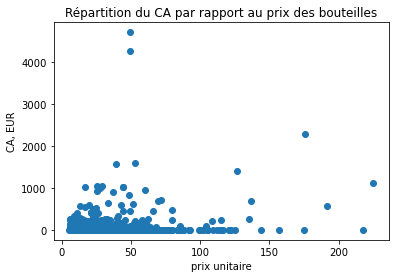

In [30]:
#CA par rapport au prix des bouteilles.

plt.scatter(web_erp['price'],web_erp['sales'])
plt.title("Répartition du CA par rapport au prix des bouteilles")
plt.ylabel("CA, EUR")
plt.xlabel("prix unitaire")
plt.show()

## III. Analyse des prix - Identification d'erreurs potentielles 

In [31]:
#identification des quartiles, moyenne et écart-type de la variable prix
web_erp['price'].describe()

count    825.000000
mean      32.415636
std       26.795849
min        5.200000
25%       14.600000
50%       24.400000
75%       42.000000
max      225.000000
Name: price, dtype: float64

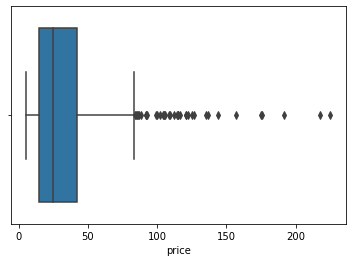

In [32]:
#visualisation des outliers 
ax = sns.boxplot(x="price" ,data=web_erp)

In [33]:
web_erp.sort_values('price', ascending=False).head()

,product_id,onsale_web,price,stock_quantity,stock_status,sku,volume_sales,post_name,sales
208,4352,1,225.0,0,outofstock,15940,5.0,champagne-egly-ouriet-grand-cru-millesime-2008,1125.0
460,5001,1,217.5,20,instock,14581,0.0,david-duband-charmes-chambertin-grand-cru-2014,0.0
635,5892,1,191.3,10,instock,14983,3.0,coteaux-champenois-egly-ouriet-ambonnay-rouge-...,573.9
227,4402,1,176.0,8,instock,3510,13.0,cognac-frapin-vip-xo,2288.0
598,5767,1,175.0,12,instock,15185,0.0,camille-giroud-clos-de-vougeot-2016,0.0


Identifions le 99 ème et le 1er percentile pour avoir une liste des valeurs potentiellement aberrantes

In [34]:
percentile_1=web_erp['price'].quantile(0.01)
percentile_1

5.92

In [35]:
#liste des bouteille dont le prix est inférieur au 1er percentile
web_erp[web_erp['price']<percentile_1].sort_values("price").reset_index()

,index,product_id,onsale_web,price,stock_quantity,stock_status,sku,volume_sales,post_name,sales
0,700,6129,1,5.2,30,instock,14570,0.0,moulin-de-gassac-igp-pays-dherault-guilhem-bla...,0.0
1,100,4172,1,5.7,167,instock,16210,43.0,maurel-pays-oc-chardonnay-2019,245.1
2,101,4173,1,5.7,100,instock,16211,13.0,maurel-pays-doc-chenin-colombard-2019,74.1
3,102,4174,1,5.7,94,instock,16209,6.0,maurel-cabardes-tradition-2017,34.2
4,605,5777,1,5.7,132,instock,14338,0.0,maurel-pays-d-oc-cabernet-sauvignon-2017,0.0
5,122,4198,1,5.8,105,instock,16322,0.0,moulin-gassac-igp-pays-herault-guilhem-rouge-2019,0.0
6,123,4200,1,5.8,190,instock,16295,46.0,moulin-de-gassac-igp-pays-dherault-guilhem-ros...,266.8
7,606,5778,1,5.8,36,instock,15561,24.0,maurel-pays-d-oc-merot-2018,139.2
8,607,5779,1,5.8,211,instock,16213,8.0,maurel-pays-d-oc-syrah-2019,46.4


In [36]:
percentile_99=web_erp['price'].quantile(0.99)
percentile_99

132.95999999999992

In [37]:
#Liste des bouteilles dont les prix sont supérieurs au 99ème percentile
web_erp[web_erp['price']>percentile_99].sort_values("price").reset_index()

,index,product_id,onsale_web,price,stock_quantity,stock_status,sku,volume_sales,post_name,sales
0,697,6126,1,135.0,10,instock,14923,2.0,champagne-gosset-celebris-vintage-2007,270.0
1,411,4904,1,137.0,13,instock,14220,5.0,domaine-des-croix-corton-charlemagne-grand-cru...,685.0
2,242,4594,1,144.0,0,outofstock,NaN,0.0,NaN,0.0
3,230,4406,1,157.0,3,instock,7819,0.0,cognac-frapin-chateau-de-fontpinot-1989-20-ans,0.0
4,598,5767,1,175.0,12,instock,15185,0.0,camille-giroud-clos-de-vougeot-2016,0.0
5,227,4402,1,176.0,8,instock,3510,13.0,cognac-frapin-vip-xo,2288.0
6,635,5892,1,191.3,10,instock,14983,3.0,coteaux-champenois-egly-ouriet-ambonnay-rouge-...,573.9
7,460,5001,1,217.5,20,instock,14581,0.0,david-duband-charmes-chambertin-grand-cru-2014,0.0
8,208,4352,1,225.0,0,outofstock,15940,5.0,champagne-egly-ouriet-grand-cru-millesime-2008,1125.0
